# Mouse Brain (10x Visium)

In [50]:
import sys
sys.path.append('E:/Anaconda/envs/SpaVAEW/Lib/site-packages/')
import glob
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt

import SpaGTL

## Data loading and preprocessing

The datasets are available at 10x genomics website.We load the dataset and perform preprocessing including finding top 2000 highly variable genes and log transformation.

In [51]:
adata = sc.read_h5ad('E:/data/Mouse_brain/V1_Adult_Mouse_Brain.h5ad')

E:\Anaconda\envs\sparcl\lib\site-packages\anndata\_core\anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [52]:
adata.var_names_make_unique()
sc.pp.filter_genes(adata, min_cells=15)
sc.pp.highly_variable_genes(adata, n_top_genes=2000, flavor='seurat_v3')
adata = adata[:, adata.var['highly_variable']]
sc.pp.log1p(adata)

E:\Anaconda\envs\sparcl\lib\site-packages\scanpy\preprocessing\_simple.py:373: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


## Graph Transfer Learning

We perform graph transfer learning on the preprocessed data.

In [53]:
params_dict = np.load('E:/data/params_dict.npy', allow_pickle=True).item()
intersection = [value for value in params_dict['genes'] if value in adata.var_names]
len(intersection)
adata=adata[:,intersection]
SpaGTL.run_SpaGTL(adata, n_epochs=1000)

100%|█████████████████████████████████████████████████████████████| 1000/1000 [00:15<00:00, 62.87it/s, loss: 1.793e+03]
E:\Anaconda/envs/SpaVAEW/Lib/site-packages\SpaGTL\_SpaGTL.py:156: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
E:\Anaconda\envs\sparcl\lib\site-packages\anndata\_core\anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


## Spatial domain identification

We identify spatial domians using the relation matrix.

[<AxesSubplot: xlabel='spatial1', ylabel='spatial2'>]

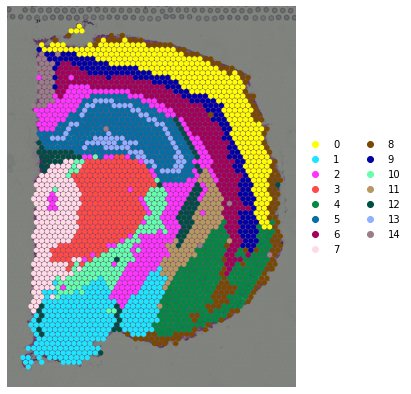

In [57]:
#sc.pp.neighbors(adata, use_rep='qz')
#sc.tl.leiden(adata, resolution=1)
#adata.obs['leiden'].to_csv('./leiden.csv')
c=pd.read_csv('./leiden.csv',index_col=0)
adata.obs['leiden']=c['leiden'].astype('category')
fig, axs = plt.subplots(figsize=(7, 7))
sc.pl.spatial(
    adata,
    img_key='hires',
    color='leiden',
    size=1.5,
    palette=sc.pl.palettes.default_102,
    legend_loc='right margin',
    frameon=False,
    title='', 
    show=False,
    ax=axs,
)

## Regulon inference and aucell

We perform regulon inference using gene relation matrix.

In [59]:
from yaml import Loader, Dumper
import glob
MOTIF_ANNOTATIONS_FNAME='E:/data/CisTarget/motifs-v9-nr.mgi-m0.001-o0.0.tbl'
tf_names=np.array((pd.read_table('E:/data/CisTarget/mm_mgi_tfs.txt',header=None).iloc[:,0]))
DATABASES_GLOB='E:/data/CisTarget/mm9-*.mc9nr.feather'
db_fnames = glob.glob(DATABASES_GLOB)
db_fnames
SpaGTL.regulons(adata, tf_names, MOTIF_ANNOTATIONS_FNAME, db_fnames, neighbors_var_key='QK')


2024-07-12 19:48:13,528 - pyscenic.utils - INFO - Creating modules.
E:\Anaconda\envs\sparcl\lib\site-packages\pyscenic\utils.py:189: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df = adjacencies.groupby(by=COLUMN_NAME_TARGET).apply(lambda grp: grp.nlargest(n, COLUMN_NAME_WEIGHT))


Create regulons from a dataframe of enriched features.
Additional columns saved: []


We perform aucell to compute the activity of each regulon on each spot.

100%|█████████████████████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 117.77it/s]

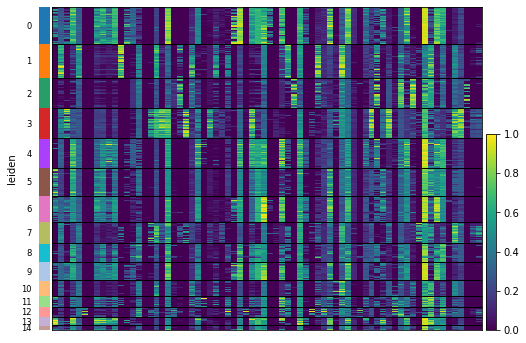

In [60]:
adata.X=adata.layers['x4']
SpaGTL.aucell(adata, normalize=True)
SpaGTL.heatmap_aucell(adata, adata.obsm['aucell'].columns, groupby='leiden')

We create a new object adata_aucell using the aucell matrix for visualization.

In [61]:
adata_aucell = sc.AnnData(adata.obsm['aucell'])
adata_aucell.obs = adata.obs.copy()
adata_aucell.obsm = adata.obsm.copy()
adata_aucell.uns['spatial'] = adata.uns['spatial'].copy()

## Finding differentially activity regulons

We find the differentially activity regulons across identified domains and show the domains and their differentially activity regulons patterns in spatial coordinates.

In [62]:
sc.tl.rank_genes_groups(adata_aucell, groupby='leiden', method='t-test_overestim_var')

In [63]:
pd.DataFrame(adata_aucell.uns['rank_genes_groups']['names']).iloc[:10,:]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,Mef2c(+),Ets2(+),Sox10(+),Zic1(+),Tbx15(+),Anxa11(+),Nfib(+),Tcf7l2(+),Tbx15(+),Nfib(+),Pitx2(+),Six3(+),Hmgb2(+),Anxa11(+),Neurod2(+)
1,Elk1(+),Nkx2-4(+),Six6(+),Shox2(+),Nkx2-1(+),Sebox(+),Tbr1(+),Lhx9(+),Foxc1(+),Pou3f1(+),Isl1(+),Otx2(+),Foxc2(+),Egr1(+),Pou3f1(+)
2,Hlf(+),Otp(+),Nmral1(+),Gbx2(+),Foxc1(+),Bhlhe22(+),Jun(+),Sox14(+),Bhlhe22(+),Tbr1(+),Sp9(+),Sp9(+),Otx2(+),Ovol2(+),Sp8(+)
3,Pou3f1(+),Pitx2(+),Hnf1b(+),Rora(+),Bhlhe22(+),Egr1(+),Nkx2-1(+),Gata3(+),Rxrg(+),Mafa(+),Tcf7l2(+),Lmx1a(+),Tbx3(+),Sebox(+),Tbr1(+)
4,Foxc1(+),Lhx6(+),Hmgb2(+),Lef1(+),Egr4(+),Egr3(+),Nr4a3(+),Zic4(+),Egr3(+),Mef2c(+),Foxc2(+),Nkx2-1(+),Lmx1a(+),Bhlhe22(+),Hlf(+)
5,Ovol2(+),Barhl1(+),Sp9(+),Irx2(+),Smad3(+),Ovol2(+),Neurod2(+),Zic5(+),Neurod2(+),Hlf(+),Sox10(+),Junb(+),Six6(+),Egr4(+),Bhlhe22(+)
6,Tbr1(+),Isl1(+),Zic3(+),Zic4(+),Neurod1(+),Neurod2(+),Elk1(+),Pitx2(+),Mef2c(+),Neurod2(+),Gata3(+),Nkx2-4(+),Rax(+),Elk1(+),Mef2c(+)
7,Nfkb2(+),Bsx(+),Isl1(+),Tcf7l2(+),Sp8(+),Tbx15(+),Sp8(+),Foxp2(+),Foxc2(+),Bcl11a(+),Pbx3(+),Rfx3(+),Nkx2-4(+),Egr3(+),Elk1(+)
8,Egr3(+),Gata3(+),Rxrg(+),Bcl11a(+),Nr4a3(+),Sp9(+),Pou3f1(+),Irx2(+),Rfx3(+),Sp8(+),Lhx6(+),Tbx15(+),Six3(+),Neurod2(+),Smad3(+)
9,Mafa(+),Lmx1a(+),Foxc2(+),Gata3(+),Jun(+),Smad3(+),Ovol2(+),Gbx2(+),Smad3(+),Elk1(+),Shox2(+),Anxa11(+),Cebpb(+),Smad3(+),Foxc2(+)


[<AxesSubplot: title={'center': 'Sox10(+)'}, xlabel='spatial1', ylabel='spatial2'>,
 <AxesSubplot: title={'center': 'leiden'}, xlabel='spatial1', ylabel='spatial2'>]

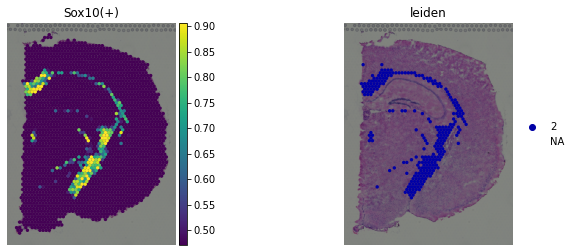

In [110]:
sc.pl.spatial(
    adata_aucell,
    img_key='hires',
    color=['Sox10(+)','leiden'],
    frameon=False,
    alpha_img=1,
    size=1.65,
    palette=color,
    colorbar_loc='right',
    vmin='p90',
    vmax='p99',
    show=False,
    groups=[2]
)

[<AxesSubplot: title={'center': 'Gbx2(+)'}, xlabel='spatial1', ylabel='spatial2'>,
 <AxesSubplot: title={'center': 'leiden'}, xlabel='spatial1', ylabel='spatial2'>]

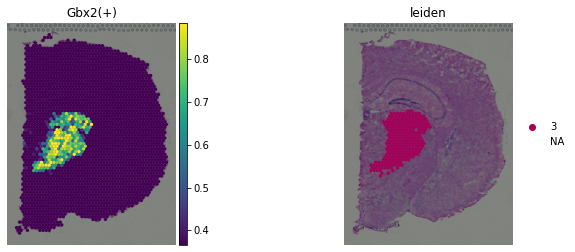

In [108]:
sc.pl.spatial(
    adata_aucell,
    img_key='hires',
    color=['Gbx2(+)','leiden'],
    frameon=False,
    alpha_img=1,
    size=1.65,
    palette=color,
    colorbar_loc='right',
    vmin='p90',
    vmax='p99',
    show=False,
    groups=[3]
)